<a href="https://colab.research.google.com/github/vizhnu/PlantId/blob/master/single_image_process_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single image preprocessing and feature extraction - Testfile

This file explores the techniques to be used for preprocessing and feature extraction for the Flavia leaves dataset images.

### Importing necessary libraries

In [0]:
pip install mahotas

In [0]:
import os
import zipfile
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
#import mahotas

### Reading the image

###### Note: 'Flavia leaves dataset' should be in the project root containing Flavia images.

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
with zipfile.ZipFile('My Drive/LeafData.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [0]:
ds_path = "/content/LeafData"

In [5]:
test_img_path = ds_path + "/leaf2/l2nr019.tif"
test_img_path

'/content/LeafData/leaf2/l2nr019.tif'

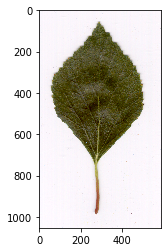

In [0]:
main_img = cv2.imread(test_img_path)
img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Converting image to grayscale

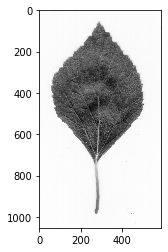

In [0]:
gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(gs,cmap='Greys_r')

In [0]:
gs.shape

(1053, 591)

### Smoothing image using Guassian filter of size (25,25)

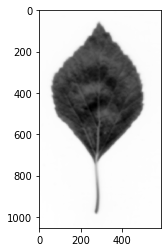

In [0]:
blur = cv2.GaussianBlur(gs, (25,25),0)
plt.imshow(blur,cmap='Greys_r')

### Adaptive image thresholding using Otsu's thresholding method

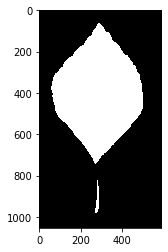

In [0]:
ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(im_bw_otsu,cmap='Greys_r')

### Closing of holes using Morphological Transformation

Performed so as to close any holes present in the leaf

In [0]:
kernel = np.ones((50,50),np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

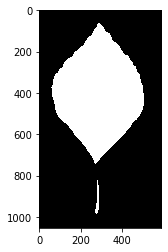

In [0]:
plt.imshow(closing,cmap='Greys_r')

# Boundary extraction

Boundary extraction is needed which will be used in calculation of shape features.

### Boundary extraction using sobel filters - Not effective

Trying to extract the boundary of the leaf using sobel filters. The image after edge extraction is thresholded using Otsu's method. Then the gaps were closed using Closing operation of Morphological Transformation.

This method is not effective as even after performing morphological transformation, gaps still persist.

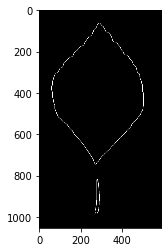

In [0]:
sobelx64f = cv2.Sobel(closing,cv2.CV_64F,1,0,ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)
plt.imshow(abs_sobel64f,cmap='Greys_r')

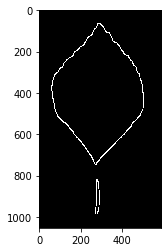

In [0]:
ret_sobel,im_bw_sobel = cv2.threshold(sobel_8u,1,255,cv2.THRESH_BINARY)
plt.imshow(im_bw_sobel,cmap='Greys_r')

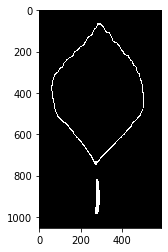

In [0]:
kernel_edge = np.ones((15,15),np.uint8)
closing_edge = cv2.morphologyEx(im_bw_sobel, cv2.MORPH_CLOSE, kernel_edge)
plt.imshow(closing_edge,cmap='Greys_r')

### Boundary extraction using contours - Effective 

Contours are used to extract leaf boundaries. They are continous, sharp and there are no gaps between the boundary pixels

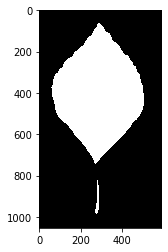

In [0]:
plt.imshow(closing,cmap="Greys_r")

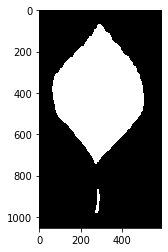

In [0]:
kernel = kernel = np.ones((10,10),np.uint8)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
plt.imshow(opening,cmap="Greys_r")

In [0]:
contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [0]:
len(contours)

2

In [0]:
index = 0
if len(contours) > 1:
  list_len = [len(c) for c in contours]
  index = list_len.index(max(list_len))
  cnt = contours[index]
else:
  cnt = contours[0]

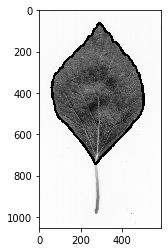

In [0]:
plottedContour = cv2.drawContours(gs,contours,index,(0,255,0),10)
plt.imshow(plottedContour,cmap="Greys_r")

## Morphological processing

## 1. Shape based features

### Calculating moments using contours

In [0]:
M = cv2.moments(cnt)
M

{'m00': 179427.0,
 'm01': 72113082.33333333,
 'm02': 32566017327.833332,
 'm03': 15966068021421.102,
 'm10': 51193614.5,
 'm11': 20566665829.583332,
 'm12': 9293916709295.85,
 'm20': 16528158737.666666,
 'm21': 6639073335550.116,
 'm30': 5805011730479.051,
 'mu02': 3583218509.2936935,
 'mu03': -2708983092.404297,
 'mu11': -8439017.398597717,
 'mu12': 9054287428.10144,
 'mu20': 1921738491.134037,
 'mu21': 1095638431.8798828,
 'mu30': -7366929258.719727,
 'nu02': 0.11130065012873745,
 'nu03': -0.00019864919290222811,
 'nu11': -0.00026212973629029295,
 'nu12': 0.0006639491013953916,
 'nu20': 0.05969235280680618,
 'nu21': 8.0342948915356e-05,
 'nu30': -0.0005402154614828714}

In [0]:
area = cv2.contourArea(cnt)
area

179427.0

In [0]:
perimeter = cv2.arcLength(cnt,True)
perimeter

1782.8855493068695

### Fitting in the best-fit rectangle and ellipse

The best-fit rectangle is chosen and not ellipse as removes (leaves out) some portion at the extreme ends of the leaf image.

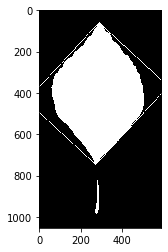

In [0]:
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
contours_im = cv2.drawContours(closing,[box],0,(255,255,255),2)
plt.imshow(contours_im,cmap="Greys_r")

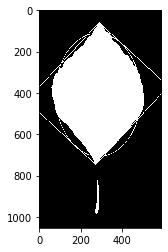

In [0]:
ellipse = cv2.fitEllipse(cnt)
im = cv2.ellipse(closing,ellipse,(255,255,255),2)
plt.imshow(closing,cmap="Greys_r")

### Shape based features calculated - Aspect ratio, rectangularity, circularity etc.

In [0]:
x,y,w,h = cv2.boundingRect(cnt)
aspect_ratio = float(w)/h
aspect_ratio

0.6486090775988287

In [0]:
rectangularity = w*h/area
rectangularity

1.6863069660641932

In [0]:
circularity = ((perimeter)**2)/area
circularity

17.715733317322687

In [0]:
equi_diameter = np.sqrt(4*area/np.pi)
equi_diameter

477.9681493501382

In [0]:
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)

## 2. Color based features

### Calculating color based features - mean, std-dev of the RGB channels

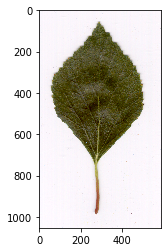

In [0]:
plt.imshow(img,cmap="Greys_r")

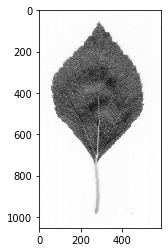

In [0]:
red_channel = img[:,:,0]
plt.imshow(red_channel,cmap="Greys_r")

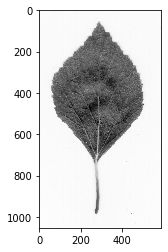

In [0]:
green_channel = img[:,:,1]
plt.imshow(green_channel,cmap="Greys_r")

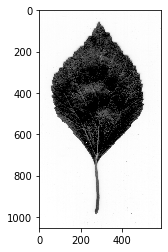

In [0]:
blue_channel = img[:,:,2]
plt.imshow(blue_channel,cmap="Greys_r")

In [0]:
np.mean(blue_channel)

184.3555966917501

In [0]:
blue_channel[blue_channel == 255] = 0
green_channel[green_channel == 255] = 0
red_channel[red_channel == 255] = 0

In [0]:
red_mean = np.mean(red_channel)
red_mean

190.837786808458

In [0]:
green_mean = np.mean(green_channel)
green_mean

194.55654378835428

In [0]:
blue_mean = np.mean(blue_channel)
blue_mean

166.08625745794387

In [0]:
red_var = np.std(red_channel)
red_var

86.04150870632338

## 3. Texture based features 

### Using Haralick moments - calculating texture based features such as contrast, correlation, entropy

In [0]:
import mahotas as mt

In [0]:
textures = mt.features.haralick(gs)
ht_mean = textures.mean(axis=0)
ht_mean

array([ 1.60877230e-02,  1.84336628e+02,  9.88064005e-01,  7.72142301e+03,
        4.35736195e-01,  3.79590382e+02,  3.07013554e+04,  5.99227879e+00,
        8.45292411e+00,  6.89181495e-04,  3.30530858e+00, -3.42016406e-01,
        9.84335318e-01])

In [0]:
print(ht_mean[1]) #contrast
print(ht_mean[2]) #correlation
print(ht_mean[4]) #inverse difference moments
print(ht_mean[8]) #entropy

184.3366283757652
0.9880640051220071
0.4357361952568042
8.45292410857629
